In [1]:
import json
import importlib
import os
import sys
import xml
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from src.utils import parse_lipid, parse_p_value, tight_bbox
from src import plots
import src.Fig4_subplots
importlib.reload(plots)

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import Normalize, TwoSlopeNorm, CenteredNorm
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['axes.unicode_minus'] = False  # https://stackoverflow.com/questions/43102564/matplotlib-negative-numbers-on-tick-labels-displayed-as-boxes
plt.style.use('seaborn-ticks')  # 'seaborn-ticks', 'seaborn-white', 'seaborn'
# sns.set_style('white')

from sklearn.preprocessing import StandardScaler
import networkx as nx
from scipy.cluster.hierarchy import linkage
from scipy.stats import pearsonr, spearmanr
# import pylustrator

In [2]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
colors['Non-fasted'] = colors['RBG']
colors['Fasted'] = colors['FBG']
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
    
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

In [3]:
data['signif_interaction'] = data['qval_sampling:ogtt'] < 0.05
data['signif_sampling'] = data['qval_sampling'] < 0.05
gb_means = (data
            .loc[:, data_cols]
            .groupby(fg['bg_type'], axis=1)
            .mean()
           )

data['fasted_mean'] = gb_means['FBG']
data['fed_mean'] = gb_means['RBG']
data['Log2 Fold Change'] = data['fed_mean'] - data['fasted_mean']

data['Fed - Fasted slope'] = data['coef_fed'] - data['coef_fasted']
data['signif_sampling'] = data['qval_sampling'] < 0.05
data['signif_interact'] = data['qval_sampling:ogtt'] < 0.05
data['log_qval_sampling'] = -np.log10(data['qval_sampling'])
data['log_qval_ogtt'] = -np.log10(data['qval_ogtt'])
data['log_qval_sampling:ogtt'] = -np.log10(data['qval_sampling:ogtt'])
data['is_id'] = data['superclass'] != 'Unidentified'

# The polar metabolomics figure might be improved with some enrichment/network analysis
## Generate data table for Metaboanalyst and draw figures

## Enrichment node:
1. can use Lipids or Metabolites in Concentration table
1. Can do 2-category categorical or a continuous regression group

## Pathway node:
1. Compound list or Concentration table 
1. 2-category or continuous regression group

## Joint-pathway node:
1. Only usable with metabolites & genomic or transcriptomic data

## Network node:
1. Concentration table with Metabolites 
1. Multinomial categorical Groups

In [4]:
df = (data
    .loc[(data['ID'] != 'Unidentified')]
    .set_index('ID')
    .loc[:, data_cols])
df = 2**df
df.rename({'4-Hydroxybutyric acid (GHB)': '4-Hydroxybutyric acid'}, inplace=True)
metabs = df.loc[df.index.isin(data.loc[data['Type'] == 'metabolite', 'ID'])].T
lipids = df.loc[df.index.isin(data.loc[data['Type'] == 'lipid', 'ID'])].T
metabs.insert(0, 'Groups', None)
lipids.insert(0, 'Groups', None)

## Create list of metabolites we detect and are found in hmdb as a reference metabolome (AKA background database)

In [5]:
metabs = metabs.drop([
    'Pentose sugar', 
    'Hexose sugar',
    'Anhydrohexose',
    'N-Methyl-2-pyrrolidone',
    'Methylaminopyrimidine',
    '8-Hydroxyquinoline',
    '5,5-Dimethylhydantoin',
    '2-Mercaptoethanol',
       ], axis=1)
metabs.rename({
    'Ethyl-beta-D-glucuronide': 'Ethyl glucuronide',
    'Ascorbic acid 2-sulfate': 'Ascorbic acid',
    'Indole-3-acrylic acid': 'Indoleacrylic acid',
    'N3,N4-Dimethyl-L-arginine': 'Asymmetric dimethylarginine',
    'N-Isovalerylglycine': 'Isovalerylglycine',
    'Methylhistidine': '1-Methylhistidine',
}, axis=1, inplace=True)
metabs.columns

(metabs
 .columns[1:]
 .to_frame()
 .to_clipboard('../data/metaboanalyst/metabolites_detected.csv', index=False, header=False, sep='\n'))

# Generate csv files for each analysis node

## Enrichment node 

In [6]:
df = metabs.copy()
df['Groups'] = df.index.map(fg['bg_type'])
df.to_csv('../data/metaboanalyst/enrichment/input_enr_sampling_metabs.csv')

df = lipids.copy()
df['Groups'] = df.index.map(fg['bg_type'])
df.to_csv('../data/metaboanalyst/enrichment/input_enr_sampling_lipids.csv')

df = metabs.copy()
df['Groups'] = df.index.map(fg['ogtt'])
df.to_csv('../data/metaboanalyst/enrichment/input_enr_ogtt_metabs.csv')

df = metabs.copy()
df['Groups'] = df.index.map(fg['ogtt'])
df = df.loc[fg['bg_type'] == 'RBG']
df.to_csv('../data/metaboanalyst/enrichment/input_enr_ogtt_metabs_fedonly.csv')

df = metabs.copy()
df['Groups'] = df.index.map(fg['ogtt'])
df = df.loc[fg['bg_type'] == 'FBG']
df.to_csv('../data/metaboanalyst/enrichment/input_enr_ogtt_metabs_fastedonly.csv')

df = lipids.copy()
df['Groups'] = df.index.map(fg['ogtt'])
df = df.loc[fg['bg_type'] == 'RBG']
df.to_csv('../data/metaboanalyst/enrichment/input_enr_ogtt_lipids.csv')

df = lipids.copy()
df['Groups'] = df.index.map(fg['ogtt'])
df = df.loc[fg['bg_type'] == 'RBG']
df.to_csv('../data/metaboanalyst/enrichment/input_enr_ogtt_lipids_fedonly.csv')

df = lipids.copy()
df['Groups'] = df.index.map(fg['ogtt'])
df = df.loc[fg['bg_type'] == 'FBG']
df.to_csv('../data/metaboanalyst/enrichment/input_enr_ogtt_lipids_fastedonly.csv')

## Pathway node

In [7]:
df = metabs.copy()
df['Groups'] = df.index.map(fg['bg_type'])
df.to_csv('../data/metaboanalyst/pathway/input_pathway_sampling_metabs.csv')

df = metabs.copy()
df['Groups'] = df.index.map(fg['ogtt'])
df.to_csv('../data/metaboanalyst/pathway/input_pathway_ogtt_metabs.csv')

## Network node

In [8]:
df = metabs.copy()
df = df.loc[fg['bg_type'] == 'RBG']
df['Groups'] = df.index.map(fg['animal'])
df.to_csv('../data/metaboanalyst/network/input_network_fedonly_animalgroups_metabs.csv')

# The outputs from enrichment, pathway and network nodes are quite sparsely populated with our metabolite IDs in the sets (with few exceptions)
# However the results suggest pathways that make sense, so write down the metabolite sets manually 
## Metaboanalyst is clunky because it doesn't save results online, closes your session after 10 minutes, and has scattered organization system for raw file downloads

# Conclusion
### After going through Enrichment and Pathway Nodes with the (1) fed-only OGTT-grouped data and (2) the fasted vs. fed-grouped data, I only found 5 KEGG pathway nodes with decent # metabolites found, and 1 Blood-based disease signature pathway 
### Network node only returned a reasonable result using Debiased Sparse Partial Correlation (DSPC) network on the fed-only OGTT-grouped data
### Using network node on fasted-vs-fed data opened up the other 5 network possibilities, but only 1 worked (KEGG Global metabolic network) and it was so big it was hard to get anything interesting out of it 
### These metabolite sets can be named and their metabolite components can be plotted in a connection graph based on the DSPC network graph file I downloaded at `~/data/metaboanalyst/network/.graphml` file

In [9]:
metab_sets = {
    'KEGG_pathway': 
    {
    'Glycine, serine and threonine metabolism': ['Choline', 'Betaine', 'Threonine', 'Glyceric acid', 'Creatine'],
    'Valine, leucine and isoleucine biosynthesis': ['Threonine', 'Leucine', 'Isoleucine'],
    'Glycerophospholipid metabolism': ['Choline', 'alpha-Glycerylphosphorylcholine'],
    'Arginine and proline metabolism': ['Arginine', 'Creatine', 'Proline', 
                                        'Glutamic acid', 'Ornithine', '4-Guanidinobutanoic acid'],
    'Aminoacyl-tRNA biosynthesis': ['Asparagine', 'Histidine', 'Phenylalanine', 'Arginine', 'Glutamine',
                                    'Alanine', 'Isoleucine', 'Leucine', 'Threonine', 
                                    'Tryptophan', 'Tyrosine', 'Proline', 'Glutamic acid',] 
    },
    'Blood_disease_signature': 
    {'DIABETES MELLITUS (MODY), NON-INSULIN-DEPENDENT': ['Glucose', 'Trigonelline', '3-Hydroxybutyric acid',
                                                         'Taurine', 'Glutamine', 'Tryptophan', 'Histidine',
                                                         'Isoleucine', 'Leucine', 'Creatinine', 'Creatine']
    }
}

In [10]:
aa = {
    'Alanine': 'Ala',
    'Arginine': 'Arg',
    'Asparagine': 'Asn',
    'Aspartic acid': 'Asp',
    'Cysteine': 'Cys',
    'Glutamine': 'Gln',
    'Glutamic acid': 'Glu',
    'Glycine': 'Gly',
    'Histidine': 'His',
    'Isoleucine': 'Ile',
    'Leucine': 'Leu',
    'Lysine': 'Lys',
    'Methionine': 'Met',
    'Phenylalanine': 'Phe',
    'Proline': 'Pro',
    'Serine': 'Ser',
    'Threonine': 'Thr',
    'Tryptophan': 'Trp',
    'Tyrosine': 'Tyr',
    'Valine ': 'Val'
}
aa_deriv = ['Taurine', 'Stachydrine', 'Phenylacetyleglycine', 'Ornithine', 
            '1-Methylhistidine', 'N-Acetylornithine', 'Betaine', 'Beta alanine'
           ]

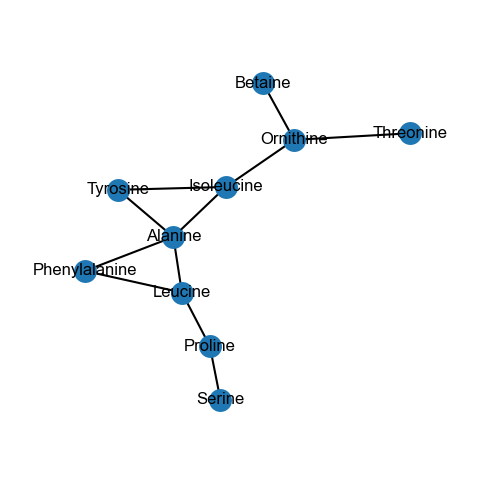

In [11]:
g = nx.read_graphml('../data/metaboanalyst/network/fed_only_ogtt_groups_graph.graphml')
gnodes = pd.read_csv('../data/metaboanalyst/network/fed_only_ogtt_groups_graph_node_names.csv').set_index('Label')
gnodes['node'] = list(g.nodes)
g = nx.relabel_nodes(g, dict(zip(gnodes['node'], gnodes.index)))

# subg = g.subgraph(metab_sets['KEGG_pathway']['Glycine, serine and threonine metabolism'])
subg = g.subgraph(list(aa.keys()) + aa_deriv)
largest_group = max(list(nx.connected_components(subg)), key=len)
subg = subg.subgraph(largest_group)
fig, ax = plt.subplots(figsize=(4,4), dpi=150)
nx.draw_networkx(
    subg, 
#     pos=nx.spring_layout(subg, seed=3), 
    pos=nx.kamada_kawai_layout(subg),
    ax=ax,
    font_size=8, node_size=100,
                 
)

ax.margins(0.15)
sns.despine(bottom=True, left=True)

In [12]:
# nodelist = gnodes.loc[gnodes['Degree'] > 6].index
# nodelist = gnodes.loc[gnodes['Betweenness'] > 0].index
# nodelist = gnodes.loc[gnodes.index.isin(
#     metab_sets['KEGG_pathway'][ 'Aminoacyl-tRNA biosynthesis'])].index
# subgraph = g.subgraph(nodelist)

# fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
# nx.draw_networkx(
#     subgraph,
#     pos=nx.spring_layout(subgraph),
#     font_size=3,
#     nodelist=nodelist,
#     node_size=100, node_color='lightblue',
# )
# sns.despine(bottom=True, left=True)

# Clustermap of metabolites 

In [13]:
# fasted_cmdf = (data
#         .loc[(data['Type'] == 'metabolite') & 
#              (data['ID'] != 'Unidentified') & 
#              ~(data['ID'].isin(['Hexose sugar', 'Pentose sugar', 'Anhydrohexose']))] 
#         .loc[:, fbg_cols]
#         .T
#         .loc[:, data['molec_class'].isin(['Amino acid', 'Amino acid derivative', 'Carbohydrate'])]
#         .corr('pearson')
#        )
# fasted_cmdf.index = fasted_cmdf.columns = data.loc[fasted_cmdf.columns, 'ID']
# cm = sns.clustermap(data=fasted_cmdf, metric='euclidean', method='complete', figsize=(0.1, 0.1))

# fasted_values = cm.ax_heatmap.collections[0].get_array().reshape(fasted_cmdf.shape)
# mask = np.tril(np.ones_like(fasted_cmdf))
# fasted_values = np.ma.array(fasted_values, mask=mask)
# # cm.ax_heatmap.collections[0].set_array(heatmap_values)
# cm.fig.set_visible(False)

# Combine two clustermaps into one:
## Upper triangle = Fed data
## Lower triangle = Fasted data

1. Make clustermap from Fed data
2. Get linkage from Fed data
3. Make clustermap on Fasted data using linkage from Fed
    1. `fig.set_visible(False)` to hide this clustermap
4. Get the triangle from each clustermap, and combine into one 
    1. `numpy.MaskedArray.filled(0)` on each
5. Assign values using `cm.ax_heatmap.collections[0].set_array(combined)`

C:\Users\bjanderson23\anaconda3\lib\site-packages\seaborn\matrix.py:1203: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.

findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, DejaVu Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, DejaVu Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, DejaVu Sans, Bitstream Vera Sans, sans-serif


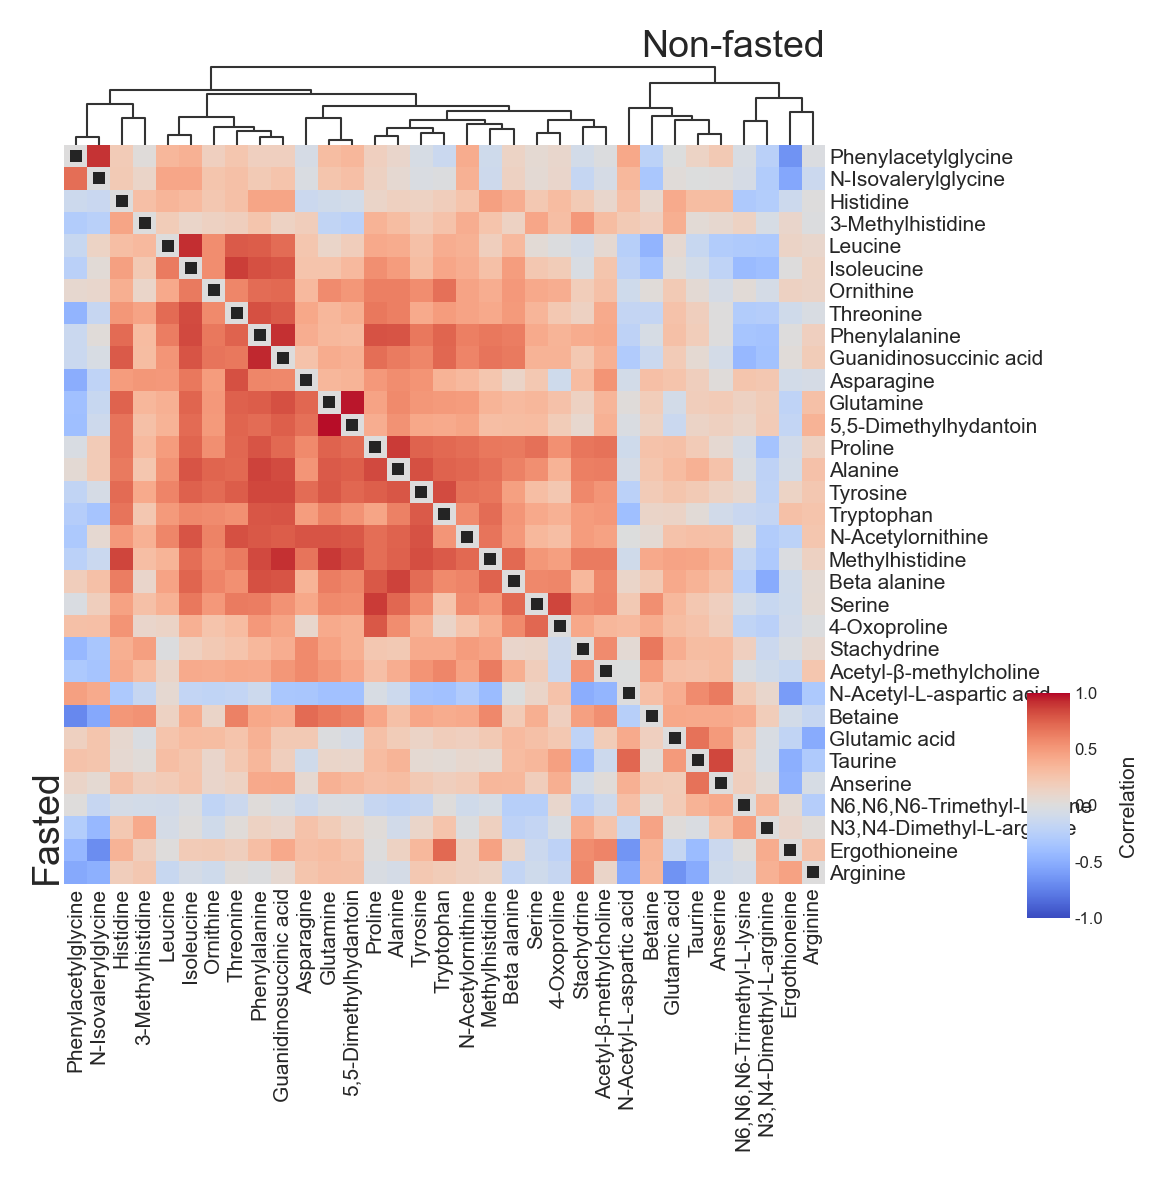

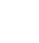

In [14]:
fed_cmdf = (data.loc[(data['Type'] == 'metabolite') & 
                     (data['ID'] != 'Unidentified') & 
                     ~(data['ID'].isin(['Hexose sugar', 'Pentose sugar', 'Anhydrohexose']))
                     & (data['molec_class'].isin(['Amino acid', 'Amino acid derivative', 
#                                                   'Carbohydrate', 'Organic acid'
                                                 ])) 
                     , rbg_cols].T.corr('pearson'))
fasted_cmdf = (data.loc[(data['Type'] == 'metabolite') & 
                        (data['ID'] != 'Unidentified') & 
                        ~(data['ID'].isin(['Hexose sugar', 'Pentose sugar', 'Anhydrohexose']))
                        & (data['molec_class'].isin(['Amino acid', 'Amino acid derivative', 
#                                                      'Carbohydrate', 'Organic acid'
                                                    ])) 
                        , fbg_cols].T.corr('pearson'))

fed_cmdf.index = fed_cmdf.columns = data.loc[fed_cmdf.columns, 'ID']
cmcolors = fed_cmdf.index.map(lambda x: data.loc[data['ID'] == x, 'molec_class'].values[0]).map(colors)
fed_cm = sns.clustermap(
    data=fed_cmdf, cmap='coolwarm', figsize=(4.8,5), metric='euclidean', method='complete', 
    dendrogram_ratio=[0.00001, 0.1], colors_ratio=0.08, center=0, vmin=-1, vmax=1, 
)
fed_linkage = fed_cm.dendrogram_col.linkage
fasted_cm = sns.clustermap(data=fasted_cmdf, row_linkage=fed_linkage, col_linkage=fed_linkage, figsize=(0.1,0.1),
                           metric='euclidean', method='complete')
fasted_cm.fig.set_visible(False)

fed_values = fed_cm.ax_heatmap.collections[0].get_array().reshape(fed_cmdf.shape)
mask = np.tril(np.ones_like(fed_cmdf))
fed_values = np.ma.array(fed_values, mask=mask)

fasted_values = fasted_cm.ax_heatmap.collections[0].get_array().reshape(fasted_cmdf.shape)
mask = np.triu(np.ones_like(fasted_cmdf))
fasted_values = np.ma.array(fasted_values, mask=mask)

combined_values = (fed_values.filled(0) + fasted_values.filled(0))

fed_cm.ax_heatmap.collections[0].set_array(combined_values)

fig = fed_cm.fig
cbar = fed_cm.ax_cbar
hm = fed_cm.ax_heatmap

fig.set(dpi=300, facecolor='white')
fig.add_gridspec(hspace=0, wspace=-10)

cbar.tick_params(axis='both', length=0, labelsize=4, pad=1)
cbar.set_ylabel('Correlation', fontsize=5)
hm.tick_params(length=0, labelsize=5, pad=1)
hm.set(yticks=np.arange(0.5, len(fed_cmdf)+0.5), xticks=np.arange(0.5, len(fed_cmdf)+0.5), 
       ylabel=None, xlabel=None,
       yticklabels=fed_cm.data2d.index, xticklabels=fed_cm.data2d.index);
fed_cm.gs.update(wspace=0.0005, hspace=0.0005)
cbar.set_position((0.7, 0.4, 0.03, 0.15))

hm.text(0, 0, 'Fasted', transform=hm.transAxes, fontsize=9, ha='right', va='bottom', rotation=90)
hm.text(1, 1.11, 'Non-fasted', transform=hm.transAxes, fontsize=9, ha='right', va='bottom')

hm.scatter(x=np.arange(0.5, len(fed_cmdf)+0.5, 1), y=np.arange(0.5, len(fed_cmdf)+0.5, 1),
           c='0.14', marker='s', s=9.5, linewidths=0)

# cm.ax_heatmap.add_patch(patches.Rectangle((0,0), 20, 20, facecolor='none', edgecolor='0.1'))
# trp_idx = [x.get_text() for x in fed_cm.ax_heatmap.get_xticklabels()].index('Tryptophan')
# ghb_idx = [x.get_text() for x in fed_cm.ax_heatmap.get_xticklabels()].index('4-Hydroxybutyric acid (GHB)')
# fed_cm.ax_heatmap.add_patch(patches.Rectangle((trp_idx, trp_idx), 19, 19, facecolor='none', edgecolor='0.2', linewidth=1))
# cm.ax_heatmap.add_patch(patches.Rectangle((31,31), 12, 12, facecolor='none', edgecolor='0.1'))
# fig.savefig('../reports/figures/Fig4_metabolomics/fasted_vs_fed_heatmap.pdf', dpi=300, bbox_inches='tight')

## Make another heatmap that shows correlation

In [15]:
# Possible interesting metabolite subsets
s1 = ['Betaine', 'Asparagine', 'Acetyl-β-methylcholine', 'Tyrosine', 'Ergothioneine', '3-Methylhistidine',]

s2 = ['Beta alanine', 'Alanine', 'N-Acetylneuraminic acid', '4-Oxoproline',]

s3 = ['Ribose', 'Iditol', 'Glutamic acid', 'Taurine', 'Anserine', 'N-Acetyl-L-aspartic acid', 
      'Phenylacetylglycine', 'N-Isovalerylglycine']

s4 = s2 + ['Threonic acid', 'Phenylalanine', 'Proline', 'Serine', 'Gluconic acid',
           'Tryptophan', 'Glyceric acid', 'Methylhistidine', 'Glucose']
s5 = s4 + ['Tyrosine', 'N-Acetylornithine', 'Hippuric acid', '3-Hydroxybutyric acid',
           '4-Hydroxybutyric acid (GHB)', 'Carnitine']

# Make network in python 

In [16]:
df = (data
 .loc[(data['Type'] == 'metabolite') & (data['ID'] != 'Unidentified'), data_cols]
 .T
 .corr('spearman')
 .reset_index()
 .rename({'i': 'i1'}, axis=1)  # Prevents a bug
 .melt(id_vars='i1')
)
df.columns = ['to', 'from', 'corr']
df = df.loc[(df['to'] != df['from']) & (df['corr'].abs() > 0.85 )]

g = nx.from_pandas_edgelist(df, 'to', 'from')
largest_group = max(list(nx.connected_components(g)), key=len)
subg = g.subgraph(largest_group)


# Add OGTT correlation as attribute to each node
for node in subg.nodes:
    subg.nodes[node]['coef_fed'] = data.loc[node, 'coef_fed']
    subg.nodes[node]['coef_fasted'] = data.loc[node, 'coef_fasted']


# subg = nx.relabel_nodes(subg, data.loc[list(subg), 'ID'].to_dict())

In [17]:
def slope_signif(qval, coef):
    if qval > 0.05:
        return 'ns'
    if coef >= 0:
        return 'pos'
    if coef < 0:
        return 'neg'
data[['qval_fasted', 'coef_fasted']].apply(lambda x: slope_signif(x[0], x[1]), axis=1)

i
m_0      pos
m_1       ns
m_2       ns
m_3       ns
m_4       ns
        ... 
l_912     ns
l_913     ns
l_914     ns
l_915     ns
l_916     ns
Length: 1409, dtype: object

In [18]:
def get_name_to_index(name):
    return data.loc[data['ID'] == name].index[0]

In [19]:
g = nx.read_graphml('../data/metaboanalyst/network/fed_only_ogtt_groups_graph.graphml')
gnodes = pd.read_csv('../data/metaboanalyst/network/fed_only_ogtt_groups_graph_node_names.csv').set_index('Label')
gnodes['node'] = list(g.nodes)
gnodes['i'] = gnodes.index.map(dict(zip(data['ID'], data.index)))
g = nx.relabel_nodes(g, dict(zip(gnodes['node'], gnodes['i'])))

In [20]:
metab_sets

{'KEGG_pathway': {'Glycine, serine and threonine metabolism': ['Choline',
   'Betaine',
   'Threonine',
   'Glyceric acid',
   'Creatine'],
  'Valine, leucine and isoleucine biosynthesis': ['Threonine',
   'Leucine',
   'Isoleucine'],
  'Glycerophospholipid metabolism': ['Choline',
   'alpha-Glycerylphosphorylcholine'],
  'Arginine and proline metabolism': ['Arginine',
   'Creatine',
   'Proline',
   'Glutamic acid',
   'Ornithine',
   '4-Guanidinobutanoic acid'],
  'Aminoacyl-tRNA biosynthesis': ['Asparagine',
   'Histidine',
   'Phenylalanine',
   'Arginine',
   'Glutamine',
   'Alanine',
   'Isoleucine',
   'Leucine',
   'Threonine',
   'Tryptophan',
   'Tyrosine',
   'Proline',
   'Glutamic acid']},
 'Blood_disease_signature': {'DIABETES MELLITUS (MODY), NON-INSULIN-DEPENDENT': ['Glucose',
   'Trigonelline',
   '3-Hydroxybutyric acid',
   'Taurine',
   'Glutamine',
   'Tryptophan',
   'Histidine',
   'Isoleucine',
   'Leucine',
   'Creatinine',
   'Creatine']}}

In [21]:
short_names = {
    '4-Hydroxybutyric acid (GHB)': 'GHB',
    'alpha-Glycerylphosphorylcholine': 'GPC',
    '3-Hydroxybutyric acid': 'BHB',
}

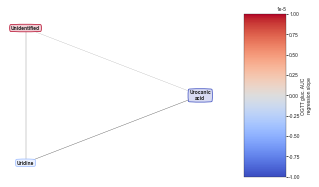

In [22]:
# import networkx as nx

# short_names = {
#     '4-Hydroxybutyric acid (GHB)': 'GHB',
#     'alpha-Glycerylphosphorylcholine': 'GPC',
#     '3-Hydroxybutyric acid': 'BHB',
# }

# def plot_graph(metab_set, corr=0.5, corr_type='spearman', 
#                layout=nx.kamada_kawai_layout, use_connec_comp=True, ax=None, cax=None):
#     if ax is None and cax is None:
#         fig, ax = plt.subplots(ncols=1, figsize=(5, 3), 
# #                                       gridspec_kw=dict(width_ratios=(5, 1))
#                                      )
        
#     # Check if metab_set is list of 'm_100' or compound names
#     if metab_set[0][1] != '_':
#         list_length = len(metab_set)
#         metab_set = data.loc[data['ID'].isin(metab_set)].index.to_list()
#         if list_length != len(metab_set):
#             raise ValueError('Could not find all metabolite names in metab_set')
    
#     df = (data
#      .loc[metab_set, rbg_cols]
#      .T
#      .corr(corr_type)
#      .reset_index()
#      .rename({'i': 'i1'}, axis=1)  # Prevents a bug
#      .melt(id_vars='i1')
#     )
#     df.columns = ['to', 'from', 'corr']
#     df = df.loc[(df['to'] != df['from']) & (df['corr'].abs() > corr)]
#     display(df)
#     g = nx.from_pandas_edgelist(df, 'to', 'from')
    
#     if use_connec_comp:
#         largest_group = max(list(nx.connected_components(g)), key=len)
#         g = g.subgraph(largest_group)
        
#     # Get edgewidths for connecting lines
#     edge_widths = []
#     for edge in g.edges:
#         corr = df.loc[(df['to'] == edge[0]) & (df['from'] == edge[1]), 'corr'].iloc[0]
#         width = 0.05 + 0.4*1/-np.log(abs(corr))  # fancy code to convert higher correlation value into thicker line
#         if width > 3.5:  # Set a cap on linewidth 
#             width = 3.5
#         edge_widths.append(width)
        
#     # Colorbar
#     ogtt_fed_coefs = data.loc[metab_set, 'coef_fed'].to_list()
#     sm = plt.matplotlib.cm.ScalarMappable(norm=plt.matplotlib.colors.CenteredNorm(), cmap='coolwarm')
#     sm.set_array(ogtt_fed_coefs)
    
#     pos = layout(g)
#     for i, (x, y) in pos.items():
#         name = data.loc[i, 'ID']
#         if name in short_names:
#             name = short_names[name]
#         coef = data.loc[i, f'coef_{bg_type}']
#         qval_slope = data.loc[i, f'qval_{bg_type}']
#         c = sm.to_rgba(coef)[:-1]
#         alpha = 0.2
#         lighter_c = [x + (1 - x) * (1 - alpha) for x in c]
#         bbox_style = dict(boxstyle='round4', pad=.3, mutation_scale=0, linewidth=0.7, 
#                           edgecolor=c, facecolor=lighter_c, alpha=1)
#         text = ax.text(x, y, name.replace(' ', '\n'), 
#                        ha='center', va='center', bbox=bbox_style, fontsize=5, fontweight='semibold')
#     nx.draw_networkx_edges(g, pos=pos, ax=ax, width=edge_widths, 
#                            edge_color='0.33',  # edge_color=[(pos_corr_color if x else neg_corr_color) for x in is_pos_corr]
#                           )
#     cbar = ax.get_figure().colorbar(mappable=sm, cax=cax)
#     cbar.outline.set_linewidth(0.3)
# #     cax.yaxis.set_label_position('right')
# #     cax.tick_params(length=2, pad=1, labelsize=5)
# #     cax.set_ylabel('OGTT gluc. AUC \nregression slope', # $mg\cdot min \cdot dL^{-1}$
# #                    labelpad=14, rotation=90, ha='center', va='center', fontsize=7)  
#     handles = [
#     #     patches.Patch(color=pos_corr_color, label='Positive profile corr.'),
#     #     patches.Patch(color=neg_corr_color, label='Negative profile corr.'),
#         patches.Patch(color='0.2', label='Low profile\ncorrelation'),
#         patches.Patch(color='0.2', label='High profile\ncorrelation')]
#     # legend = ax1.legend(handles=handles, loc=(-0.1, 1), fontsize=6)
#     # for patch, height in zip(legend.legendHandles, [2, 8]):
#     #     patch.set_width(15)
#     #     patch.set_height(height)
#     sns.despine(left=True, bottom=True, ax=ax)
#     return ax, cbar
    
importlib.reload(src.plots)
ax, cbar = plots.plot_graph(metab_set=['m_1', 'm_2', 'm_3'], corr=0.0)

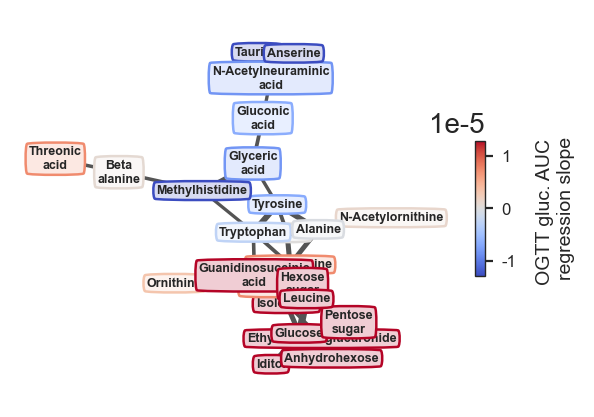

In [24]:
bg_type = 'fed'
df = (data
 .loc[(data['ID'] != 'Unidentified'), (rbg_cols if bg_type == 'fed' else fbg_cols)]
 .T
 .corr('pearson')
 .reset_index()
 .rename({'i': 'i1'}, axis=1)  # Prevents a bug
 .melt(id_vars='i1')
)
df.columns = ['to', 'from', 'corr']
df = df.loc[(df['to'] != df['from']) & (df['corr'].abs() > 0.7)]
g = nx.from_pandas_edgelist(df, 'to', 'from')

# metab subsets:
# metab_set = metab_sets['KEGG_pathway']['Aminoacyl-tRNA biosynthesis']
# metab_set = metab_sets['KEGG_pathway']['Glycine, serine and threonine metabolism'] + ['Serine', 'Threonine']
# metab_set = data.loc[(data['Type'] == 'metabolite') & (data['ID'] != 'Unidentified'), 'ID']
metab_set = data.loc[data['molec_class'].isin([
                                               'Amino acid', 
                                               'Amino acid derivative', 
                                               'Carbohydrate', 
                                               'Organic acid'
                                               'Nitrogen heterocycle'
                                              ]), 'ID']
# metab_set = [
#     'Leucine', 'Isoleucine', #'Threonine',     
#     'AC 5:0', 'AC 4:0', 'AC 3:0', 'AC 2:0', 'AC 18:2', 'AC 18:1',     
#     'AC 18:0', 'AC 16:1', 'AC 16:0', 'AC 14:1', 'AC 14:0']  # spearman = 0.4 or 0.38
# metab_set = metab_sets['Blood_disease_signature']['DIABETES MELLITUS (MODY), NON-INSULIN-DEPENDENT']
# metab_set = ['Choline', 'alpha-Glycerylphosphorylcholine'] + list(set(data.loc[data['molec_class'] == 'TG', 'ID']))
# metab_set = data.loc[data['molec_class'] == 'Amino acid derivative', 'ID']

# metab_set = (data.loc[data['molec_class'].isin(['Organic acid']), 'ID']
#                  .drop(['m_135', 'm_138', 'm_8', 'm_115', 'm_104', 'm_20', 'm_128',
# #                         'm_66', 'm_68', 'm_107', 'm_144', 'm_28', 
#                        ])).to_list() #+ ['Glucose', 'Ribose']
# metab_set = s5

subset = [get_name_to_index(x) for x in metab_set]
subg = g.subgraph(subset)
largest_group = max(list(nx.connected_components(subg)), key=len)
subg = subg.subgraph(largest_group)

is_pos_corr = [] 
edge_widths = []
for edge in subg.edges:
    corr = df.loc[(df['to'] == edge[0]) & (df['from'] == edge[1]), 'corr'].iloc[0]
    is_pos_corr.append(corr > 0)
    width = 0.05 + 0.4*1/-np.log(abs(corr))
    if width > 3.5:
        width = 3.5
#     print(corr, width)
    edge_widths.append(width)

np.random.seed(4812)
fig = plt.figure(dpi=200, facecolor='white', figsize=(3, 2.5))
gs = plt.GridSpec(10, 40, hspace=2)
ax1 = fig.add_subplot(gs[0:10, 0:35])
# ax2 = fig.add_subplot(gs[0:10, 19:35])
cax = fig.add_subplot(gs[3:7, 39:40])
# pos = nx.spectral_layout(subg)
# pos = nx.circular_layout(subg)
# pos = nx.kamada_kawai_layout(subg, scale=5)
pos = nx.spring_layout(subg, iterations=1000, seed=27)
# coolwarm = sns.color_palette('coolwarm', 5)
# slope_colormap = {'ns': coolwarm[2], 'pos': coolwarm[0], 'neg': coolwarm[-1]}
# Make Colormap https://stackoverflow.com/questions/28752727/map-values-to-colors-in-matplotlib
norm = plt.matplotlib.colors.CenteredNorm()
sm = plt.matplotlib.cm.ScalarMappable(norm=norm, cmap='coolwarm')
ravel_values = data.loc[list(subg.nodes), ['coef_fed']].values.ravel()
sm.set_array(ravel_values)
# pos['m_136'][1] += 0.6
pos_corr_color, neg_corr_color = 'forestgreen', 'purple'
for bg_type, ax in [('fed', ax1)]:
    values = data.loc[list(subg.nodes), f'coef_{bg_type}']
    for i, (x, y) in pos.items():
        name = data.loc[i, 'ID']
        if name in short_names:
            name = short_names[name]
        coef = data.loc[i, f'coef_{bg_type}']
        qval_slope = data.loc[i, f'qval_{bg_type}']
        c = sm.to_rgba(coef)[:-1]
        alpha = 0.2
        lighter_c = [x + (1 - x) * (1 - alpha) for x in c]
        bbox_style = dict(
            boxstyle='round4', pad=.3, mutation_scale=0, linewidth=0.9, facecolor=lighter_c, alpha=1, edgecolor=c)
        text = ax.text(x, y, name.replace(' ', '\n'), 
                       ha='center', va='center', bbox=bbox_style, fontsize=4.5, fontweight='semibold')
    nx.draw_networkx_edges(subg, pos=pos, ax=ax, width=edge_widths, 
                           edge_color='0.33',  # edge_color=[(pos_corr_color if x else neg_corr_color) for x in is_pos_corr]
                          )
cbar = fig.colorbar(mappable=sm, cax=cax, )
cbar.outline.set_linewidth(0.5)
# cax.text(0.5, 1.2, 'Positive corr.', ha='center', transform=cax.transAxes, fontsize=6)
# cax.text(0.5, -0.2, 'Negative corr.', ha='center', transform=cax.transAxes, fontsize=6)
cax.yaxis.set_label_position('right')
cax.tick_params(length=3, pad=3, labelsize=6)
cax.set_ylabel('OGTT gluc. AUC \nregression slope', labelpad=14, rotation=90, ha='center', va='center', fontsize=7)  # $mg\cdot min \cdot dL^{-1}$
handles = [
#     patches.Patch(color=pos_corr_color, label='Positive profile corr.'),
#     patches.Patch(color=neg_corr_color, label='Negative profile corr.'),
    patches.Patch(color='0.2', label='Low profile\ncorrelation'),
    patches.Patch(color='0.2', label='High profile\ncorrelation')]
# legend = ax1.legend(handles=handles, loc=(-0.1, 1), fontsize=6)
# for patch, height in zip(legend.legendHandles, [2, 8]):
#     patch.set_width(15)
#     patch.set_height(height)
sns.despine(left=True, bottom=True)
# plt.savefig('../reports/figures/Fig4_metabolomics/N-heterocycles_network.pdf', dpi=300, facecolor='white', bbox_inches='tight')

In [128]:
data.columns

Index(['unique_id', 'ID', 'm/z', 'RT', 'molec_class', 'Type', 'polarity',
       'lc_type', 'superclass', '1091_8_FBG', '1091_10_FBG', '1093_8_FBG',
       '1093_9_FBG', '1093_10_FBG', '1060_8_FBG', '1060_9_FBG', '1060_10_FBG',
       '1062_8_FBG', '1062_9_FBG', '1062_10_FBG', '1074_8_FBG', '1074_9_FBG',
       '1074_10_FBG', '1092_8_FBG', '1092_9_FBG', '1092_10_FBG', '1102_8_FBG',
       '1102_9_FBG', '1102_10_FBG', '1076_8_FBG', '1076_9_FBG', '1076_10_FBG',
       '1082_8_FBG', '1082_9_FBG', '1082_10_FBG', '1101_8_FBG', '1101_9_FBG',
       '1101_10_FBG', '1091_8_RBG', '1091_9_RBG', '1091_10_RBG', '1093_8_RBG',
       '1093_9_RBG', '1093_10_RBG', '1060_8_RBG', '1060_9_RBG', '1060_10_RBG',
       '1062_8_RBG', '1062_9_RBG', '1062_10_RBG', '1074_8_RBG', '1074_9_RBG',
       '1074_10_RBG', '1092_8_RBG', '1092_9_RBG', '1092_10_RBG', '1102_8_RBG',
       '1102_9_RBG', '1102_10_RBG', '1076_8_RBG', '1076_9_RBG', '1076_10_RBG',
       '1082_8_RBG', '1082_9_RBG', '1082_10_RBG', '1101_8_RBG', 

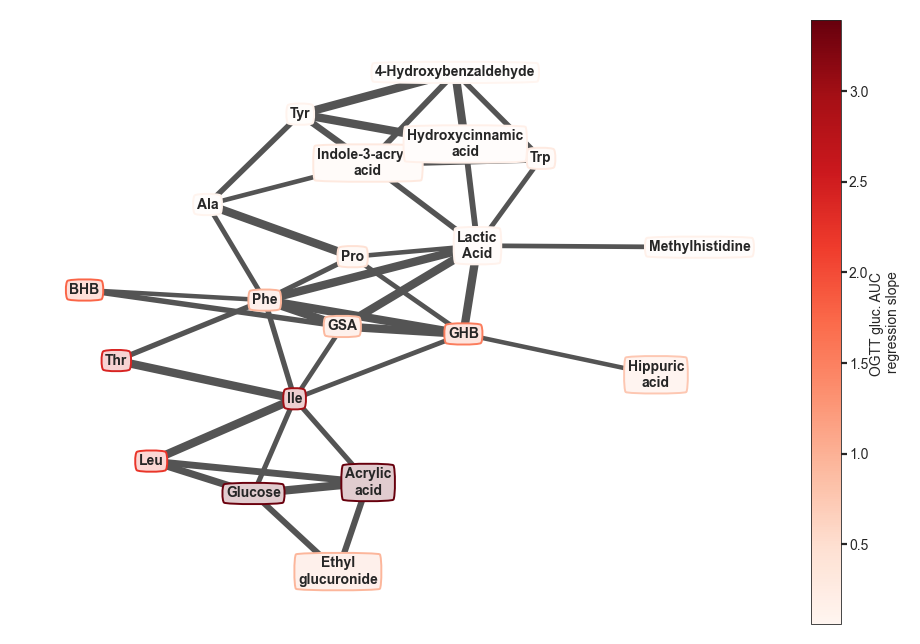

In [428]:
importlib.reload(src.plots)
# fig, ax = plt.subplots(figsize=(6, 4), dpi=200, facecolor='white')
all_ids = data.loc[(data['Type'] == 'metabolite')
                & ~(data['ID'].isin(['Unidentified', 'Hexose sugar', 'Pentose sugar', 'Anhydrohexose']))].index
all_aa = data.loc[data['molec_class'] == 'Amino acid'].index
# AC_FA = data.loc[data['molec_class'].isin(['AC'])].index
plots.plot_graph(metab_set=all_ids, 
#                  layout=nx.circular_layout, 
                 use_connec_comp=True,
                 corr=0.77, corr_type='pearson', 
                 max_linewidth=3,
#                  continuous_var='Log2 Fold Change', centered_norm=False, cmap='Reds',
                 continuous_var='log_qval_sampling:ogtt', centered_norm=False, cmap='Reds',
#                  continuous_var='log_qval_fed', centered_norm=False, cmap=sns.color_palette('Reds', as_cmap=True),
#                  continuous_var='Fed - Fasted slope',
#                  continuous_var='coef_fed',
#                  continuous_var='fed_mean', centered_norm=False, cmap='viridis'
                )
fig = plt.gcf()
fig.set_size_inches(6, 4)
fig.set_dpi(200)
fig.set_facecolor('white')

In [ ]:
plt.matplotlib.colors.Normalize()

### List of metabs that make a cool network
m_22                    Proline
m_58                 Isoleucine
m_26              Phenylalanine
m_40          N-Acetylornithine
m_56                Lactic Acid
m_9                   Threonine
m_103                Asparagine
m_72     Guanidinosuccinic acid
m_54                    Leucine
m_7                Trigonelline
m_16                Stachydrine
m_111                   Alanine

`['m_22', 'm_58', 'm_26', 'm_40', 'm_56', 'm_9', 'm_103', 'm_72', 'm_54',
       'm_7', 'm_16', 'm_111']`

Also use spearman correlation with correlation cutoff for edge > 0.85

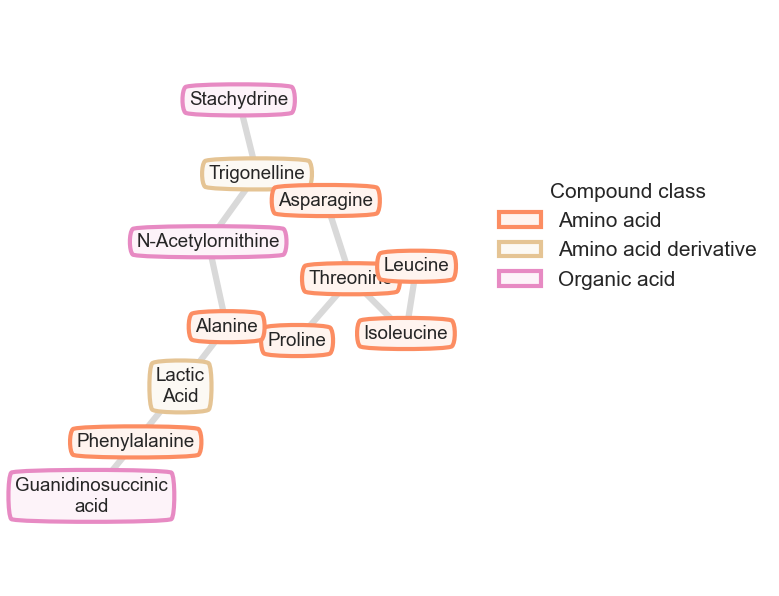

In [571]:
df = (data
 .loc[(data['Type'] == 'metabolite') & (data['ID'] != 'Unidentified'), data_cols]
 .T
 .corr('spearman')
 .reset_index()
 .rename({'i': 'i1'}, axis=1)  # Prevents a bug
 .melt(id_vars='i1')
)
df.columns = ['to', 'from', 'corr']
df = df.loc[(df['to'] != df['from']) & (df['corr'].abs() > 0.85 )]

g = nx.from_pandas_edgelist(df, 'to', 'from')
largest_group = max(list(nx.connected_components(g)), key=len)
subgraph = g.subgraph(largest_group)
subgraph = nx.relabel_nodes(subgraph, data.loc[list(subgraph), 'ID'].to_dict())

fig, ax = plt.subplots(figsize=(4,5), dpi=150, facecolor='white')
pos = nx.kamada_kawai_layout(subgraph, scale=5)
pos['Threonine'][1] += 0.11
pos['Isoleucine'][1] -= 0.04
pos['Trigonelline'][1] += 0.12
c = sns.color_palette('hls')[4]

nx.draw_networkx_edges(
    subgraph, pos=pos, edge_color='0.85', width=3,
)
# nx.draw_networkx_labels(subgraph, pos, font_size=8, clip_on=False)
texts = {}
for name, (x, y) in pos.items():
    c = colors[data.loc[data['ID'] == name, 'molec_class'].values[0]]
    alpha=0.1
    lighter_c = [x + (1 - x) * (1 - alpha) for x in c]
#     bbox_style = patches.FancyBboxPatch((0, 0), 1, 1, boxstyle='round4', linewidth=2, facecolor=lighter_c, edgecolor=c, alpha=1).properties()
    bbox_style = dict(boxstyle='round4', pad=.4, mutation_scale=0, linewidth=2,
#                       edgecolor='deepskyblue', facecolor='white', 
                      facecolor=lighter_c, alpha=1,
                      edgecolor=c,
                     )
    text = ax.text(x, y, name.replace(' ', '\n'), ha='center', va='center', bbox=bbox_style, fontsize=9)
    texts[name] = text
handles = [texts[cmpd].get_bbox_patch() for cmpd in ('Alanine', 'Trigonelline', 'Stachydrine')]
    
ax.legend(handles=handles, labels=['Amino acid', 'Amino acid derivative', 'Organic acid'], 
          title='Compound class', loc=(1.01, 0.5))
ax.margins(0.15)
sns.despine(bottom=True, left=True)
# plt.tight_layout()

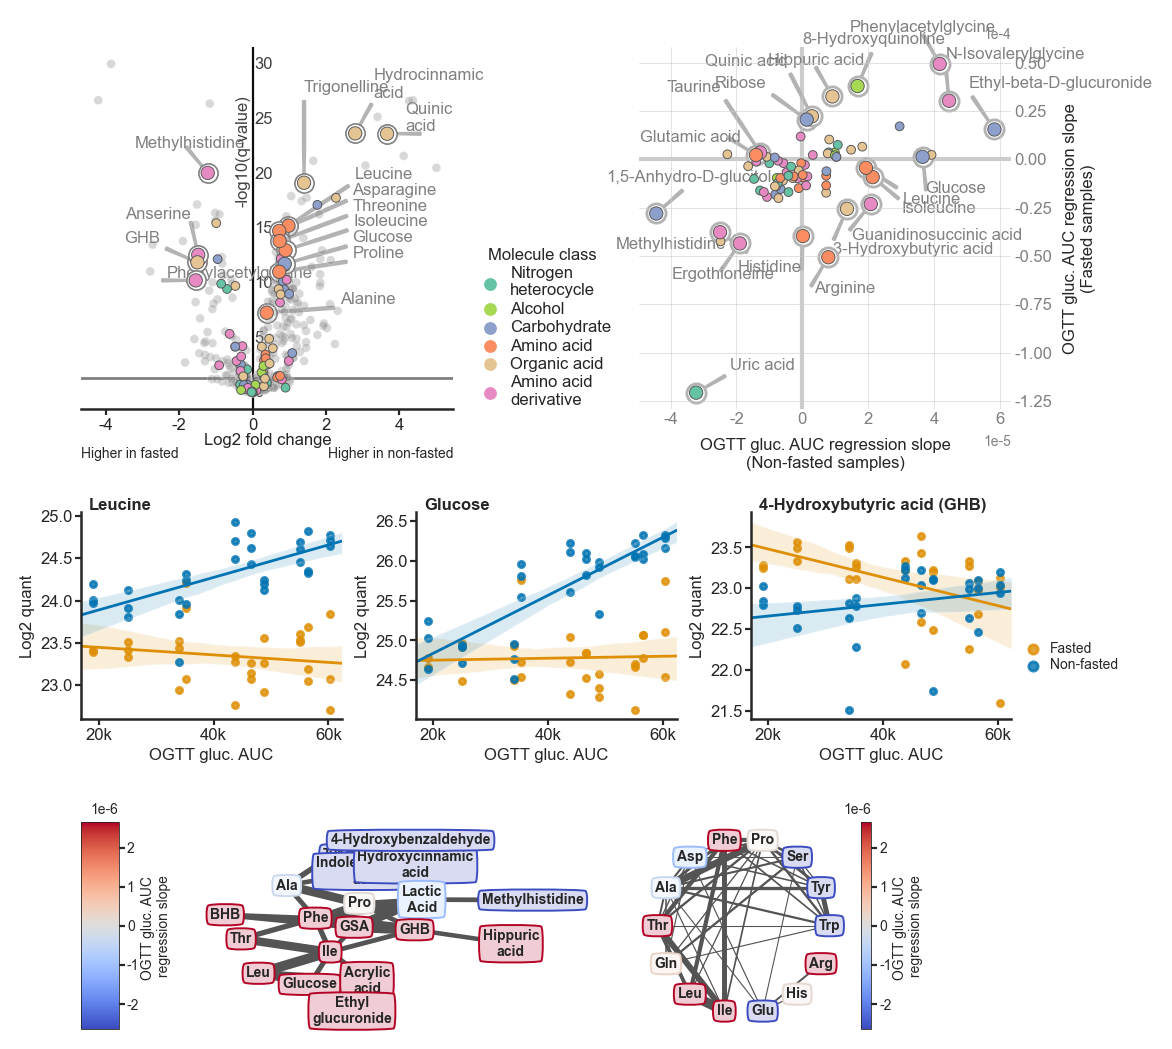

In [424]:
importlib.reload(src.Fig4_subplots)
importlib.reload(src.plots)
fig, axs = plt.subplot_mosaic(
    """
    AAAA.BBBB
    AAAA.BBBB
    AAAA.BBBB
    CCCDDDEEE
    CCCDDDEEE
    fFFFFFGGG
    fFFFFFGGG

    """,
    gridspec_kw=dict(hspace=2, wspace=2), figsize=(6, 6.5), dpi=200, facecolor='white',
)
# SET SPINE WIDTHS FOR ALL AXES
for ax in axs.values():
    for side in ['top','bottom','left','right']:
        ax.spines[side].set_linewidth(0.9)

src.Fig4_subplots.metab_volcano_plot(ax=axs['A'])
axs['A'].set_xlabel('Log2 fold change', fontsize=6, labelpad=0)

src.Fig4_subplots.metab_coef_coef_plot(ax=axs['B'])
# axs['B'].legend(loc=(0.5, 0.8), bbox_transform=fig.transFigure)

# OGTT vs Quant plots
for feature, ax in [
    (data.loc[data['ID'] == 'Leucine'].index[0], axs['C']), 
    (data.loc[data['ID'] == 'Glucose'].index[0], axs['D']), 
#     (data.loc[data['ID'] == 'N-Acetylornithine'].index[0], axs['D']),
    (data.loc[data['ID'] == '4-Hydroxybutyric acid (GHB)'].index[0], axs['E'])
#     (data.loc[data['ID'] == '3-Hydroxybutyric acid'].index[0], axs['E'])
                   ]:
    plots.plot_quant_vs_ogtt(feature, ax=ax, scatter_kws=dict(s=5), line_kws=dict(linewidth=1),
                             legend=(True if ax is axs['E'] else False))
    if ax is axs['E']:
        ax.legend(loc=(1.01, 0.2), markerscale=1.5, fontsize=5, title_fontsize=5, labelspacing=0.2,
                  handletextpad=0.2, )
    ax.tick_params(labelsize=6, pad=1, length=2)
    ax.set_xlabel('OGTT gluc. AUC', fontsize=6, labelpad=2)
    ax.set_ylabel('Log2 quant', fontsize=6, labelpad=2)
    ax.text(0.03, 1, data.loc[feature, 'ID'], fontsize=6, fontweight='semibold',
            ha='left', va='bottom', transform=ax.transAxes)
    
    
# metab_set_f = data.loc[data['molec_class'] == 'AC', 'ID'].to_list() + ['Leucine', 'Isoleucine']
metab_set_f = data.loc[(data['Type'] == 'metabolite') 
                    & ~(data['ID'].isin(['Unidentified', 'Hexose sugar', 'Pentose sugar', 'Anhydrohexose']))].index
_, cbar1 = plots.plot_graph(
    metab_set=metab_set_f, corr=0.77, corr_type='pearson',
    fontsize=5,
    ax=axs['F'], cax=axs['f'])

metab_set_g = data.loc[data['molec_class'] == 'Amino acid', 'ID'].to_list() 
_, cbar2 = plots.plot_graph(
    metab_set=metab_set_g, corr=0.3, use_connec_comp=False,   
    layout=nx.circular_layout, ax=axs['G'])

<AxesSubplot:xlabel='ogtt', ylabel='quant'>

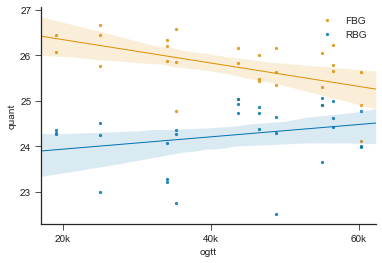

In [410]:
plots.plot_quant_vs_ogtt(feature, scatter_kws=dict(s=5), line_kws=dict(linewidth=1),
                             legend=True)

In [569]:
norm = plt.matplotlib.colors.CenteredNorm()
values = data.loc[data['molec_class'] == 'Amino acid', ['coef_fed', 'ID']]
# norm([-1, 0, 1])
values['norm'] = norm(values['coef_fed'])
values

,coef_fed,ID,norm
i,,,
m_5,-6.715887e-06,Tyrosine,0.342699
m_6,-2.643100e-06,Tryptophan,0.438093
m_9,7.226027e-06,Threonine,0.669250
m_17,-2.731353e-06,Serine,0.436025
m_22,1.072541e-07,Proline,0.502512
m_26,7.218428e-06,Phenylalanine,0.669072
m_54,1.929633e-05,Leucine,0.951964
m_58,2.134720e-05,Isoleucine,1.000000
m_64,1.724731e-07,Histidine,0.504040


<AxesSubplot:xlabel='ogtt', ylabel='quant'>

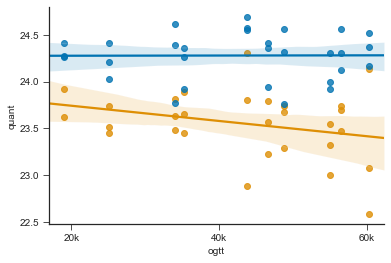

In [570]:
plots.plot_quant_vs_ogtt('m_22')

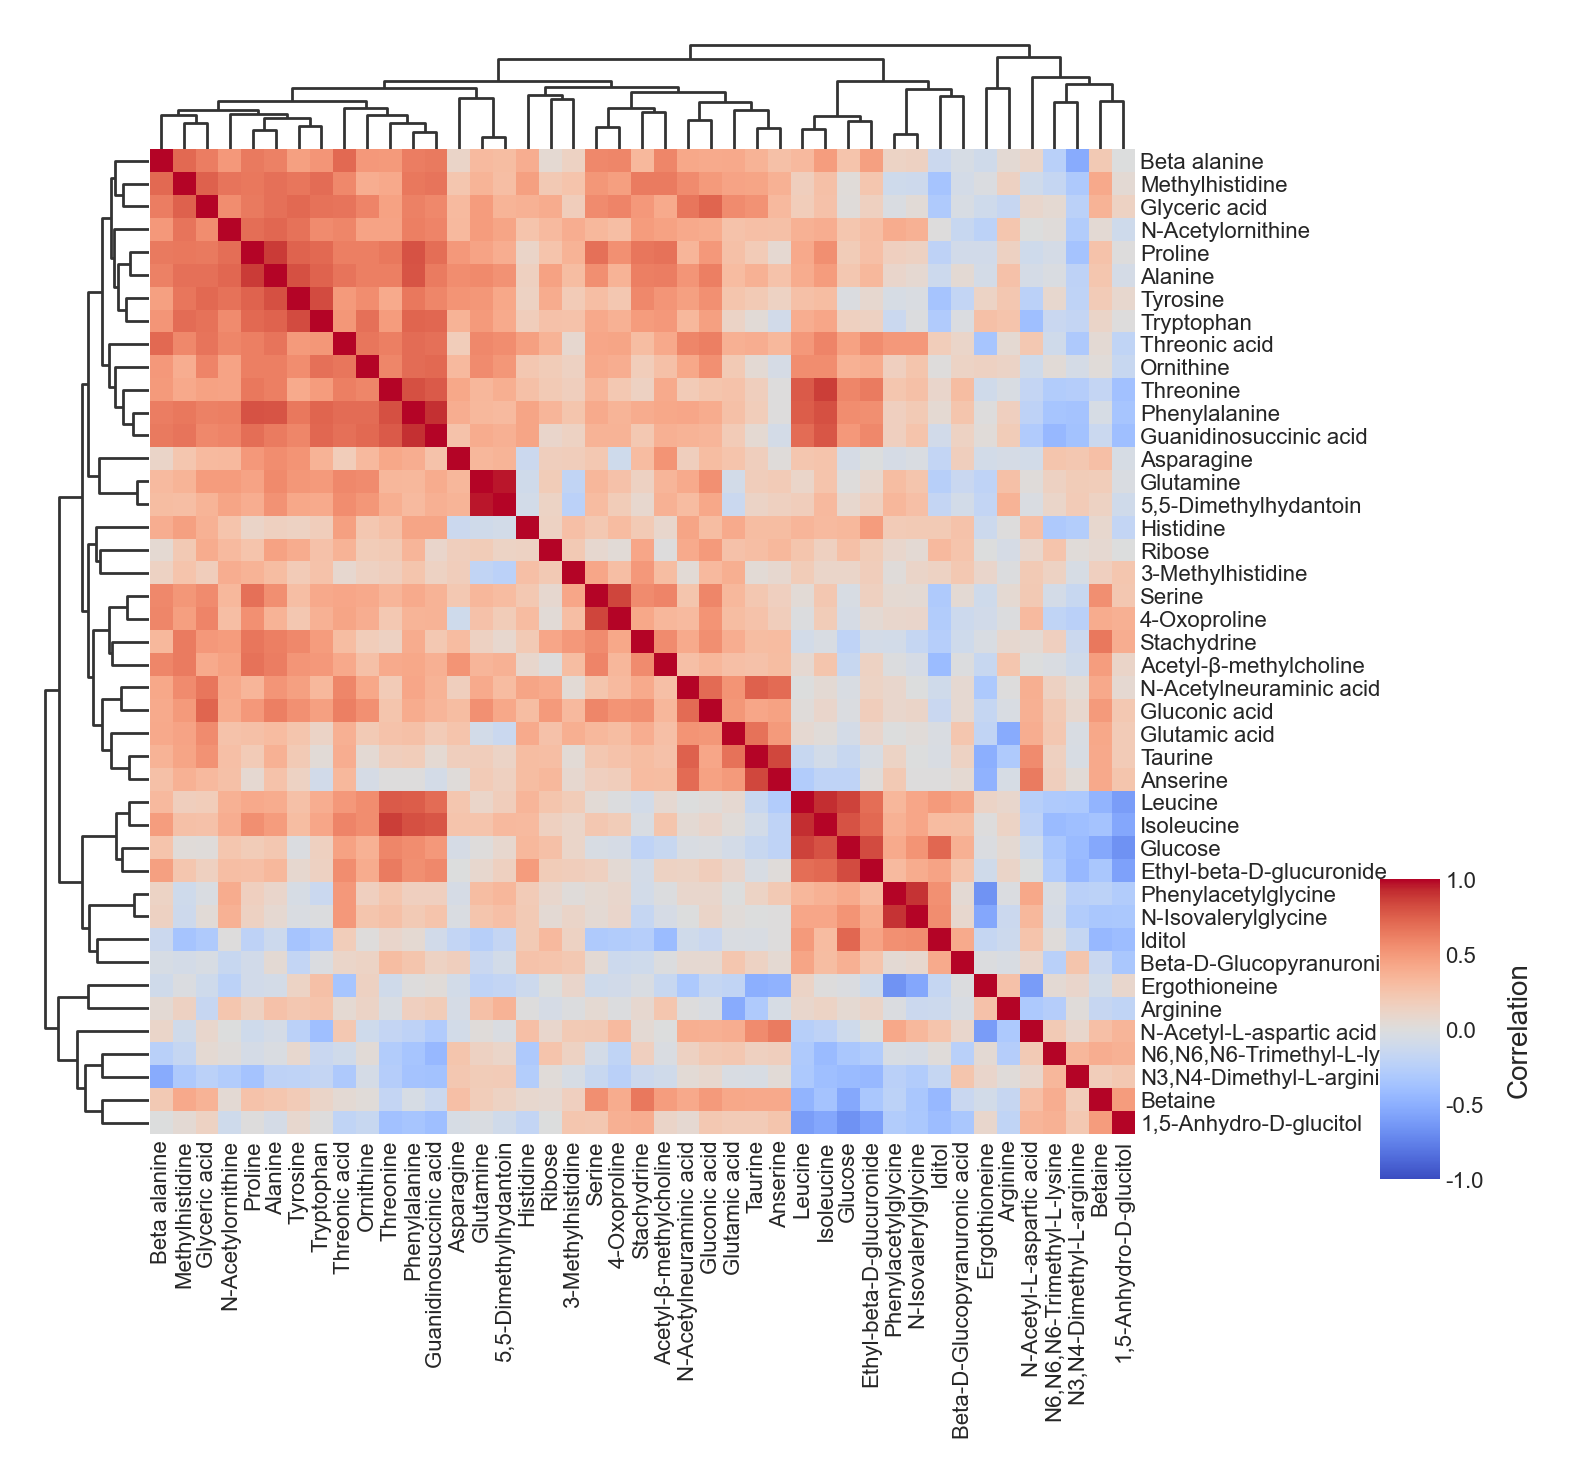

In [484]:
cmdf = (data
        .loc[(data['Type'] == 'metabolite') & 
             (data['ID'] != 'Unidentified') & 
             ~(data['ID'].isin(['Hexose sugar', 'Pentose sugar', 'Anhydrohexose'])), 
             rbg_cols]
        .T
#         .loc[:, list(subgraph.nodes)]
        .loc[:, data['molec_class'].isin(['Amino acid', 'Amino acid derivative', 'Carbohydrate'])]
        .corr('pearson')
       )
cmdf
cmdf.index = data.loc[cmdf.index, 'ID']
cmdf.columns = data.loc[cmdf.columns, 'ID']
cmcolors = cmdf.index.map(lambda x: data.loc[data['ID'] == x, 'molec_class'].values[0]).map(colors)
cm = sns.clustermap(
    data=cmdf, cmap='coolwarm', figsize=(5,5), metric='euclidean',
#     row_colors=cmcolors, col_colors=cmcolors, 
    dendrogram_ratio=0.1, colors_ratio=0.08, center=0, vmin=-1, vmax=1, 
)
fig = cm.fig
fig.set(dpi=400, facecolor='white')
fig.add_gridspec(hspace=0, wspace=-10)
cm.ax_cbar.tick_params(axis='both', length=0, labelsize=4, pad=1)
cm.ax_cbar.set_ylabel('Correlation', fontsize=5)
cm.ax_heatmap.tick_params(length=0, labelsize=4, pad=1)
cm.ax_heatmap.set(yticks=np.arange(0.5, len(cmdf)+0.5), xticks=np.arange(0.5, len(cmdf)+0.5), 
                  ylabel=None, xlabel=None,
                  yticklabels=cm.data2d.index, xticklabels=cm.data2d.index);
cm.gs.update(wspace=0.0005, hspace=0.0005)
cm.ax_cbar.set_position((0.7, 0.4, 0.03, 0.15))

# cm.ax_heatmap.add_patch(patches.Rectangle((0,0), 20, 20, facecolor='none', edgecolor='0.1'))
# cm.ax_heatmap.add_patch(patches.Rectangle((20,20), 11, 11, facecolor='none', edgecolor='0.1'))
# cm.ax_heatmap.add_patch(patches.Rectangle((31,31), 12, 12, facecolor='none', edgecolor='0.1'))

# Older analysis (testing out metaboanalyst results) below

In [104]:
g = nx.read_graphml('../data/processed/metaboanalyst_graph.graphml')

gnodes = pd.read_csv('../data/processed/metaboanalyst_graph_node_table.csv').set_index('Label')
gnodes['node'] = list(g.nodes)
gnodes

g = nx.relabel_nodes(g, dict(zip(gnodes['node'], gnodes.index)))
g.nodes

NodeView(('Alanine', 'Pentose sugar', 'Trigonelline', 'Threonine', 'Ornithine', 'Hydroxycinnamic acid', 'Indole-3-acrylic acid', 'Leucine', 'Isoleucine', 'Proline', 'Quinic acid', 'Acrylic acid', 'Phenylalanine', 'Hippuric acid', 'Hydrocinnamic acid', 'Choline', '4-Hydroxybenzaldehyde', 'Guanidinosuccinic acid', 'Tyrosine', 'Asparagine', 'Glucose', 'Lactic Acid', 'Tryptophan', 'Creatine', 'alpha-Glycerylphosphorylcholine', 'Threonic acid', 'N-Acetylneuraminic acid', 'N-Acetylornithine', 'N-Acetyl-L-aspartic acid', 'Gluconic acid', 'Anhydrohexose', 'Pipecolic acid', 'Nicotinamide 1-oxide', '3-Methylhistidine', 'Stachydrine', 'Ribose', 'Pseudouridine', 'Hexose sugar', 'Nicotinamide', 'Creatinine', 'Phenylacetylglycine', 'Carnitine', 'Histidine', 'Ergothioneine', 'Citramalic acid', 'Betaine', 'Anserine', '5,5-Dimethylhydantoin', '4-Hydroxybutyric acid'))

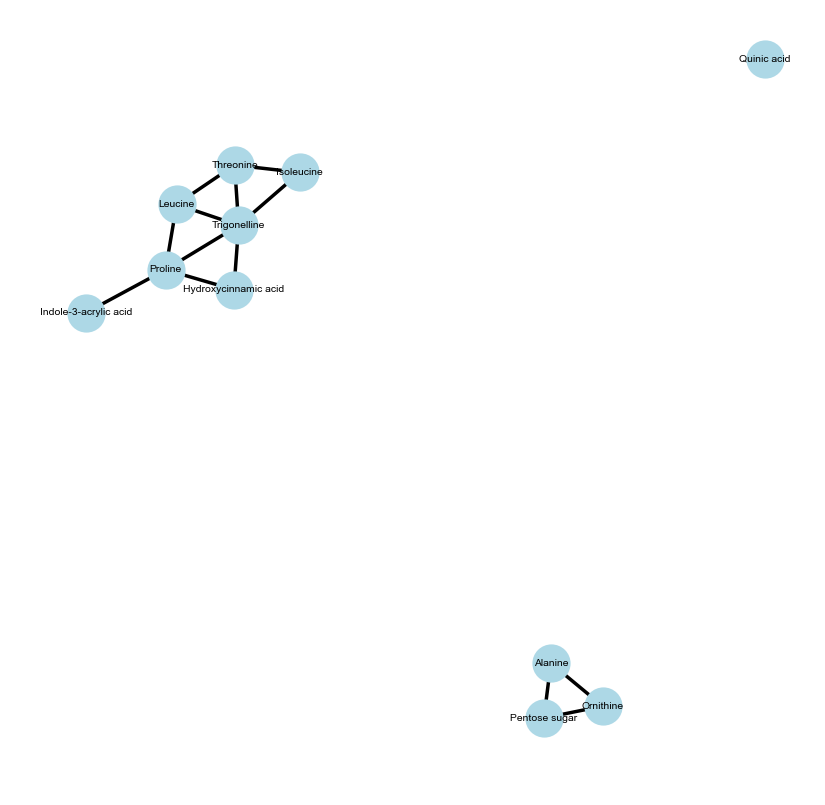

In [120]:
nodelist = gnodes.loc[gnodes['Degree'] > 6].index
# nodelist = gnodes.loc[gnodes['Betweenness'] > 0].index
subgraph = g.subgraph(nodelist)

fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
nx.draw_networkx(
    subgraph,
    pos=nx.spring_layout(subgraph),
    font_size=3,
    nodelist=nodelist,
    node_size=100, node_color='lightblue',
)
sns.despine(bottom=True, left=True)

In [10]:
data.loc[(data['Type'] == 'metabolite') & (data['ID'] != 'Unidentified'), 'ID'].values#.to_clipboard()

array(['Urocanic acid', 'Uridine', 'Uric acid', 'Tyrosine', 'Tryptophan',
       'Trigonelline', 'Indole-3-acrylic acid', 'Threonine',
       'Threonic acid', 'Taurine', 'Stachydrine', 'Serine', 'Ribose',
       'Quinic acid', 'Pseudouridine', 'Proline', 'Pipecolic acid',
       'Phenylalanine', 'Phenylacetylglycine', 'Pentose sugar',
       'Ornithine', 'Nicotinamide 1-oxide', 'Nicotinamide',
       'N6,N6,N6-Trimethyl-L-lysine', 'N3,N4-Dimethyl-L-arginine',
       'N-Methyl-2-pyrrolidone', 'N-Isovalerylglycine',
       'N-Acetylornithine', 'N-Acetylneuraminic acid',
       'N-Acetyl-L-aspartic acid', 'Methylhistidine',
       'Methylaminopyrimidine', 'Leucine', 'Lactic Acid', 'Isoleucine',
       'Hydroxycinnamic acid', 'Hydrocinnamic acid', 'Histidine',
       'Hippuric acid', 'Iditol', 'Hexose sugar',
       'Guanidinosuccinic acid', 'Glyceric acid', 'Glutamine',
       'Glutamic acid', 'Glucose', 'Gluconic acid',
       'Ethyl-beta-D-glucuronide', 'Ergothioneine', 'Cytidine',
    

In [ ]:
fig, axs = plt.subplot_mosaic(
    '''
    .AAABB
    .AAABB
    x.CCCD
    ..CCCE
    ''',
    dpi=150, figsize=(8,8), facecolor='white',
    gridspec_kw=dict(wspace=1.2, hspace=1.1, 
                     width_ratios=[1, 0.1, 4, 4, 4, 7],
                     height_ratios=[1, 1, 1, 1]),
)

axvol = plots.volcano(x='Log2 Fold Change', y='log_qval_sampling', 
                      df=data, metab_type='lipid', ax=axs['A'], legend=True)
axvol.legend(loc=(-1, 0))
axslopes = plots.fasted_fed_slope('lipid', alpha=0.8, ax=axs['B'])
axvol.tick_params(length=3)
axslopes.tick_params(length=3)

ax = make_carbon_unsat_plot('TG', 0.18, ax=axs['C'], cax=axs['x'])
num_tg = ids.loc[ids['molec_class'] == 'TG'].shape[0]
axs['C'].set_title(f'TG  n={num_tg}', fontsize=10, pad=0)
for xy, width, height in [
#     ((45.5, -0.5), 13, 3), ((45.5, 2.5), 15, 3), ((51.3, 5.5), 7.5, 4), 
    ((57.3, 9.5), 9, 9)
]:
    ax.add_patch(patches.Rectangle(xy, width, height, linewidth=1, edgecolor='0.1', facecolor='none'))

for unsat_low, unsat_high, subplot in [
    (0, 99, 'E'), 
#     (0, 2, 'C'), (3, 5, 'D'), (6, 9, 'E'), 
    (10, 99, 'D')
]:
    plot_quant_vs_ogtt(lipid_means(unsat_low, unsat_high), x='ogtt', y='quant', palette=colors, 
                       animal_lines=False, xlabel='OGTT glucose AUC', ylabel='Mean log2 quant.', 
                       scatter_kws={'s': 14, 'edgecolor': '0.2', 'linewidth': 0.25, 'zorder': 10}, 
                       line_kws={'linewidth': 1}, ax=axs[subplot])
fs=9   
axs['B'].set_xlabel('Non-fasted regression slope')
axs['B'].set_ylabel('Fasted regression slope')
axs['D'].legend(loc=(1, 0), handles=axs['D'].get_legend_handles_labels()[0], labels=['Fasted', 'Non-fasted'],
                markerscale=3,)
axs['D'].tick_params(length=3)
axs['D'].set_yticks([19, 21, 23], fontsize=fs)
axs['D'].set_xticks([20000, 40000, 60000], ['20k', '40k', '60k'], fontsize=fs)
axs['D'].set_ylabel('Mean log2 quant.', fontsize=fs)
axs['D'].set_xlabel('OGTT glucose AUC', fontsize=fs)
axs['E'].tick_params(length=3)
axs['E'].set_yticks([21, 23, 25], fontsize=fs)
axs['E'].set_xticks([20000, 40000, 60000], ['20k', '40k', '60k'], fontsize=fs)
axs['E'].set_ylabel('Mean log2 quant.', fontsize=fs)
axs['E'].set_xlabel('OGTT glucose AUC', fontsize=fs)
# handles, labels = axs['B'].get_legend_handles_labels()
# axs['B'].legend(handles=handles, labels=['Fasted', 'Non-fasted'], loc=(-1.4, 0.5), markerscale=2, title='Sampling')
axs['x'].text(s='Fasted\nHigher', x=0.5, y=-0.05, transform=axs['x'].transAxes, ha='center', va='top')
# axs['x'].yaxis.set_label_position('left')

for ax_letter, ax in axs.items():
    if ax_letter == 'x':
        continue
    bb = tight_bbox(ax)
    ax.text(s=ax_letter, x=bb.x0-0.002, y=bb.y1+0.01, fontweight='bold', transform=fig.transFigure)

# plt.savefig(r'..\reports\figures\Figure_TGs\FA_unsat_carbons_mean_regplots.png', dpi=200, bbox_inches='tight', facecolor='white')
# plt.savefig(r'..\reports\figures\Figure_TGs\FA_unsat_carbons_mean_regplots.pdf', dpi=200, bbox_inches='tight', facecolor='white')